# A2: NeuralNetwork Class

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the `05` and `06` lecture notes.  First, define your `NeuralNetwork` class to include just one hidden layer, as done in notes `05`.  Follow these steps:


* Define the `__init__` function to accept three arguments, the number of inputs in each sample (columns of `X`), the number of units in the hidden layer, and the number of outputs of the output layer, and
    * assign these values to member variables `self.n_inputs`, `self.n_hiddens_each_layer`, and `self.n_outputs`,
    * initialize a weight matrix for each layer and store them in a list in `self.Ws`, and
    * initialize `self.rmse_trace` to an empty list.
* Define the `_forward(self, X)` function that returns the output of the network, `Y`, in standardized form and create `self.Zs` as a list consisting of the input `X` and the outputs of the hidden layer.
* Define  the `_gradients(self, X, T)` function that returns the gradients of the mean square error with respect to the weights in each layer.
* Define `_calc_rmse_standardized` as shown in notes 05.
* Define the `train(self, Xtrain, Ttrain, Xtest, Ttest, n_epochs, learning_rate)` function that
    * standardizes `Xtrain` and `Ttrain` and saves the standardization parameters (means and stds) in member variables, `self.X_means`, `self.X_stds`, `self.T_means` and `self.T_stds`,
    * standardizes `Xtest` and `Ttest` using `self.X_means`, `self.X_stds`, `self.T_means` and `self.T_stds`,
    * loops for `n_epochs` as shown in notes `05` and for each loop,
        * uses the `_forward` function to calculate the outputs of all units,
        * uses the `_gradients` function to calculate the gradient of the the mean squared error respect to all weight matrices,
        * updates all weight matrices, and
        * calculates the RMSE for train and test data and appends these values to `self.rmse_trace`
* Define `use(self, X)` that
    * standardizes `X` using the standardization member variables,
    * calls `_forward` to calculate the outputs of all units,
    * unstandardizes the outputs of the network, and
    * returns these outputs.
* You may choose to define other functions, such as `_add_ones`, to be called by the functions above. Remember to name functions with a leading `_` that are not meant to be called by the users of your `NeuralNetwork` class.

No test your implementation. You may use the same example data as used in notes `05`. When you are happy with your test results:

* Copy your `NeuralNetwork` class code cell, and paste it after the code cells you used to test your one-hidden layer `NeuralNetwork` class.
* Modify the code in this new cell to allow any number of hidden layers, including no hidden layers specified by an empty list as `[]`. <font color='red'>Don't forget this case.</font> The constructor, `__init__`, must now accept a list of numbers of units in each hidden layer, rather than just a single number of units. The length of this list determines the number of hidden layers.

See the following examples for more details. Then,

* Apply your `NeuralNetwork` class to the problem of predicting the value of concrete strength as described below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd  # for display and clear_output
import time

## First Version of the `NeuralNetwork` Class - One Hidden Layer

In this next code cell, I add a new method to your class that replaces the weights created in your constructor with non-random values to allow you to compare your results with mine, and to allow our grading scripts to work well.

## Second Version of the `NeuralNetwork` Class - Multiple Hidden Layers

When your second version is working, you may delete the above code cell that defines your first version of `NeuralNetwork`.

In [3]:
# insert your NeuralNetwork class definition here.  This will be a large code cell when you are done!
class NeuralNetwork:

    def __init__(self, n_inputs_sample, n_hiddens_each_layer, n_outputs):
      self.n_inputs = n_inputs_sample
      self.n_hiddens_each_layer = n_hiddens_each_layer
      self.n_outputs = n_outputs

      # initialize weight matrices for each hidden layer
      self.Ws = []
      ni = self.n_inputs
      for nu in self.n_hiddens_each_layer:
        self.Ws.append(np.random.uniform(-1, 1, size=(1 + ni, nu)) / np.sqrt(1 + ni))
        ni = nu

      #for output layer
      nu = self.n_outputs
      self.Ws.append(np.random.uniform(-1, 1, size=(1+ni, nu)) / np.sqrt(1+ni))

      self.rmse_trace = []

    def _add_ones(self, A):
        return np.insert(A, 0, 1, axis=1)

    def _forward(self, X):

      # find zs using z = tanh(x v)
      z=X
      self.Zs = []
      self.Zs.append(z)

      for i in range(len(self.Ws) -1):
        z = np.tanh(self._add_ones(self.Zs[i]) @ self.Ws[i])
        self.Zs.append(z)

      # Y doesn't need tanh activation
      Y = self._add_ones(self.Zs[-1]) @ self.Ws[-1]
      self.Zs.append(Y)

      return Y  #Y the output

    def _gradients(self, X, T):
      Y = self.Zs[-1]

      delta = T - Y
      gradients = []

      for w in range(len(self.Ws)-1, -1,-1):
        W = self.Ws[w]
        Z = self.Zs[w]
        gradients.append(- self._add_ones(Z).T @ delta)
        delta = (delta @ W[1:, :].T) * (1 - Z**2)

      return gradients


    def _calc_rmse_standardized(self,T,Y):
      return np.sqrt(np.mean((T - Y) ** 2))

    def train(self, Xtrain, Ttrain, Xtest, Ttest, n_epochs, learning_rate):

      self.X_means = Xtrain.mean(axis=0)
      self.X_stds = Xtrain.std(axis=0)
      self.T_means = Ttrain.mean(axis=0)
      self.T_stds = Ttrain.std(axis=0)

      n_samples, n_outputs = Ttrain.shape

      rho = learning_rate / (n_samples * n_outputs)

      # standardized parameters
      XtrainS = (Xtrain - self.X_means) / self.X_stds
      TtrainS = (Ttrain - self.T_means) / self.T_stds
      XtestS = (Xtest - self.X_means) / self.X_stds
      TtestS = (Ttest - self.T_means) / self.T_stds

      for epoch in range(n_epochs):

        # call forward to find all weights
        YTrainS = self._forward(XtrainS)

        gradients = self._gradients(XtrainS,TtrainS)
        gradients.reverse()

        for w in range(len(self.Ws)):
          self.Ws[w] -= rho * gradients[w]

        # calculate rmse for train and test data
        YTestS = self._forward(XtestS)
        self.rmse_trace.append([self._calc_rmse_standardized(TtrainS, YTrainS),
                        self._calc_rmse_standardized(TtestS, YTestS)])


    def use(self, X):
      # this is the function to predict values for a given matrix of inputs
      # after the model has been trained

      # standardize X using member variables from train function
      X_S = (X - self.X_means) / self.X_stds

      # call forward to calculate output of all units and final standardized output
      Y_S = self._forward(X_S)

      # unstandardize Y
      Y = Y_S * self.T_stds + self.T_means

      return Y

In [4]:
def set_weights_for_testing(self):
    for W in self.Ws[:-1]:   # leave output layer weights at zero
        n_weights = W.shape[0] * W.shape[1]
        W[:] = np.linspace(-0.01, 0.01, n_weights).reshape(W.shape)
        for u in range(W.shape[1]):
            W[:, u] += (u - W.shape[1]/2) * 0.2
    # Set output layer weights to zero
    self.Ws[-1][:] = 0
    print('Weights set for testing by calling set_weights_for_testing()')

setattr(NeuralNetwork, 'set_weights_for_testing', set_weights_for_testing)

## Example Results

Here we test your new `NeuralNetwork` class that allows 0, 1, 2, or more hidden layers with some simple data.  


In [5]:
X = np.arange(0, 10, 0.1).reshape(-1, 1)
T = np.sin(X) + 0.01 * (X ** 2)
X.shape, T.shape

((100, 1), (100, 1))

In [6]:
# Collect every 5th sample as the test set.
test_rows = np.arange(0, X.shape[0], 5)
# All remaining samples are in the train set.
train_rows = np.setdiff1d(np.arange(X.shape[0]), test_rows)

Xtrain = X[train_rows, :]
Ttrain = T[train_rows, :]
Xtest = X[test_rows, :]
Ttest = T[test_rows, :]

print(f'{Xtrain.shape=} {Ttrain.shape=} {Xtest.shape=} {Ttest.shape=}')

Xtrain.shape=(80, 1) Ttrain.shape=(80, 1) Xtest.shape=(20, 1) Ttest.shape=(20, 1)


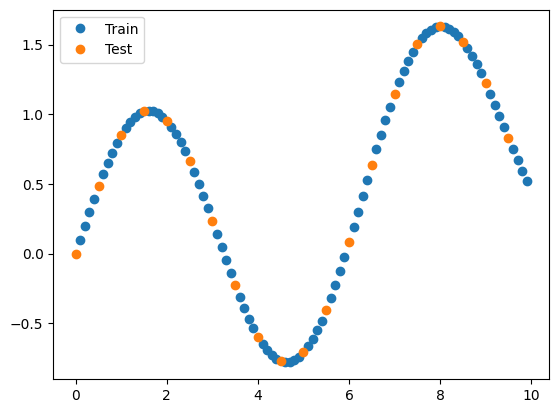

In [7]:
plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.plot(Xtest, Ttest, 'o', label='Test')
plt.legend();

In [8]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [3, 2], n_outputs)
nnet

In [9]:
nnet.n_inputs, nnet.n_hiddens_each_layer, nnet.n_outputs

(1, [3, 2], 1)

In [10]:
nnet.rmse_trace

[]

In [11]:
nnet.Ws

[array([[-0.04884685, -0.26032003, -0.07755339],
        [-0.09838272, -0.60986045,  0.0778861 ]]),
 array([[-0.37232608,  0.26100765],
        [-0.0258077 ,  0.38488735],
        [ 0.10403226, -0.00311411],
        [ 0.16097422,  0.39248634]]),
 array([[ 0.19084795],
        [ 0.21451038],
        [-0.09534424]])]

In [12]:
nnet.set_weights_for_testing()

Weights set for testing by calling set_weights_for_testing()


In [13]:
nnet.Ws

[array([[-0.31 , -0.106,  0.098],
        [-0.298, -0.094,  0.11 ]]),
 array([[-0.21      , -0.00714286],
        [-0.20428571, -0.00142857],
        [-0.19857143,  0.00428571],
        [-0.19285714,  0.01      ]]),
 array([[0.],
        [0.],
        [0.]])]

In [14]:
nnet.train(Xtrain, Ttrain, Xtest, Ttest, n_epochs=1, learning_rate=0.1)

In [15]:
nnet.Zs

[array([[-1.73291748],
        [-1.55962573],
        [-1.38633399],
        [-1.21304224],
        [-1.03975049],
        [-0.86645874],
        [-0.69316699],
        [-0.51987524],
        [-0.3465835 ],
        [-0.17329175],
        [ 0.        ],
        [ 0.17329175],
        [ 0.3465835 ],
        [ 0.51987524],
        [ 0.69316699],
        [ 0.86645874],
        [ 1.03975049],
        [ 1.21304224],
        [ 1.38633399],
        [ 1.55962573]]),
 array([[ 2.03527172e-01,  5.68329348e-02, -9.23569751e-02],
        [ 1.53544458e-01,  4.05825180e-02, -7.34264441e-02],
        [ 1.02763480e-01,  2.43106038e-02, -5.44428527e-02],
        [ 5.14411404e-02,  8.02579805e-03, -3.54198229e-02],
        [-1.54354032e-04, -8.26326587e-03, -1.63710911e-02],
        [-5.17490267e-02, -2.45479456e-02,  2.68953195e-03],
        [-1.03068918e-01, -4.08196082e-02,  2.17482009e-02],
        [-1.53845874e-01, -5.70696481e-02,  4.07910762e-02],
        [-2.03823074e-01, -7.32895056e-02,  5.9804

Why only 20 rows in these matrices?  I thought I had 80 training samples!

In [16]:
print(nnet)

In [17]:
nnet.X_means, nnet.X_stds

(array([5.]), array([2.88530761]))

In [18]:
nnet.T_means, nnet.T_stds

(array([0.51792742]), array([0.74017845]))

In [19]:
[Z.shape for Z in nnet.Zs]

[(20, 1), (20, 3), (20, 2), (20, 1)]

In [20]:
nnet.Ws

[array([[-0.31 , -0.106,  0.098],
        [-0.298, -0.094,  0.11 ]]),
 array([[-0.21      , -0.00714286],
        [-0.20428571, -0.00142857],
        [-0.19857143,  0.00428571],
        [-0.19285714,  0.01      ]]),
 array([[3.38271078e-18],
        [1.45977062e-03],
        [3.30068017e-05]])]

In [21]:
dir(nnet)

['T_means',
 'T_stds',
 'Ws',
 'X_means',
 'X_stds',
 'Zs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_ones',
 '_calc_rmse_standardized',
 '_forward',
 '_gradients',
 'n_hiddens_each_layer',
 'n_inputs',
 'n_outputs',
 'rmse_trace',
 'set_weights_for_testing',
 'train',
 'use']

In [22]:
def plot_data_and_model(nnet, Xtrain, Ttrain, Xtest, Ttest):
    plt.clf()
    plt.subplot(2, 1, 1)
    plt.plot(nnet.rmse_trace)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(('Train RMSE', 'Test RMSE'))

    plt.subplot(2, 1, 2)
    order = np.argsort(Xtrain, axis=0).flatten()
    Xtrain = Xtrain[order]
    Ttrain = Ttrain[order]
    plt.plot(Xtrain, nnet.use(Xtrain), '-', label='Ytrain')
    plt.plot(Xtrain, Ttrain, 'o', label='Ttrain', alpha=0.5)

    order = np.argsort(Xtest, axis=0).flatten()
    Xtest = Xtest[order]
    Ttest = Ttest[order]
    plt.plot(Xtest, nnet.use(Xtest), '-', label='Ytest')
    plt.plot(Xtest, Ttest, 'o', label='Ttest', alpha=0.5)

    plt.xlabel('X')
    plt.ylabel('T or Y')
    plt.legend();

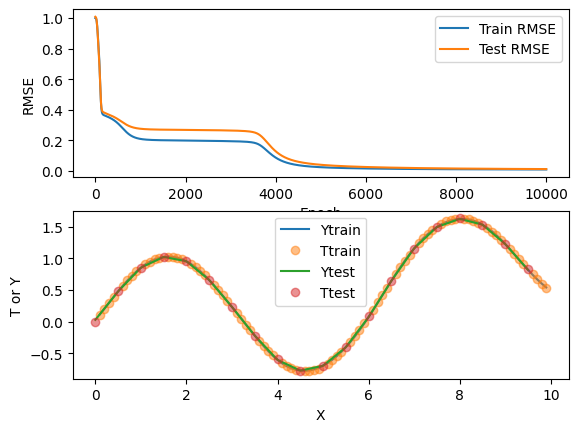

In [24]:
X = np.arange(0, 10, 0.1).reshape(-1, 1)
T = np.sin(X) + 0.01 * (X ** 2)

# Collect every 5th sample as the test set.
test_rows = np.arange(0, X.shape[0], 5)
# All remaining samples are in the train set.
train_rows = np.setdiff1d(np.arange(X.shape[0]), test_rows)

Xtrain = X[train_rows, :]
Ttrain = T[train_rows, :]
Xtest = X[test_rows, :]
Ttest = T[test_rows, :]

print(f'{Xtrain.shape=} {Ttrain.shape=} {Xtest.shape=} {Ttest.shape=}')

n_inputs = X.shape[1]
n_outputs = T.shape[1]
nnet = NeuralNetwork(n_inputs, [10, 5], n_outputs)
nnet.set_weights_for_testing()

n_epochs = 10000
n_epochs_per_plot = 200

fig = plt.figure()
for reps in range(n_epochs // n_epochs_per_plot):
    plt.clf()
    nnet.train(Xtrain, Ttrain, Xtest, Ttest, n_epochs=n_epochs_per_plot, learning_rate=0.2)
    plot_data_and_model(nnet, Xtrain, Ttrain, Xtest, Ttest)
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True)

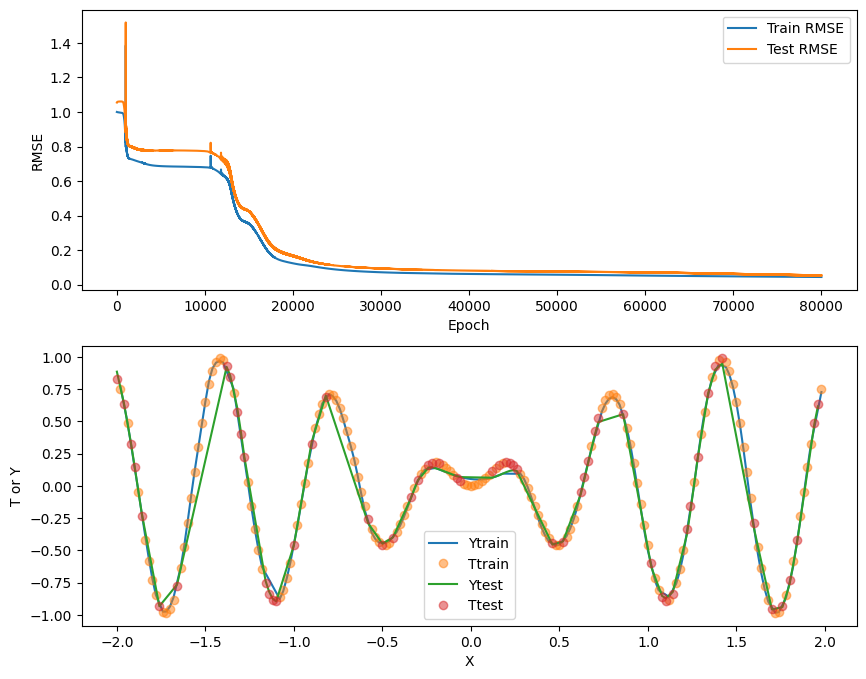

In [65]:
X = np.arange(-2, 2, 0.02).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

rows = np.arange(X.shape[0])
np.random.shuffle(rows)
ntrain = int(len(rows) * 0.7)

Xtrain = X[rows[:ntrain], :]
Ttrain = T[rows[:ntrain], :]
Xtest = X[rows[ntrain:], :]
Ttest = T[rows[ntrain:], :]

print(f'{Xtrain.shape=} {Ttrain.shape=} {Xtest.shape=} {Ttest.shape=}')

n_inputs = X.shape[1]
n_outputs = T.shape[1]
nnet = NeuralNetwork(n_inputs, [50, 10, 5], n_outputs)
nnet.set_weights_for_testing()

n_epochs = 80000
n_epochs_per_plot = 1000

fig = plt.figure(figsize=(10, 8))
for reps in range(n_epochs // n_epochs_per_plot):
    plt.clf()
    nnet.train(Xtrain, Ttrain, Xtest, Ttest, n_epochs=n_epochs_per_plot, learning_rate=0.05)
    plot_data_and_model(nnet, Xtrain, Ttrain, Xtest, Ttest)
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True)

Your results will not be the same, but your code should complete and make plots somewhat similar to these.

## Application of `NeuralNetwork` class to some concrete data!

Download data from [Calculate Concrete Strength at Kaggle](https://www.kaggle.com/datasets/prathamtripathi/regression-with-neural-networking). Read it into python using the `pandas.read_csv` function.  Assign the first 8 columns as inputs to `X` and the final column as target values to `T`.  Make sure `T` is two-dimensional.

In [26]:
import pandas

# Read the csv file as a pandas.DataFrame
df = pandas.read_csv('concrete_data.csv')

Xd = df.iloc[:, range(8)]
X_names = Xd.columns
X = Xd.values

Td = df.iloc[:, 8:9]
T_names = Td.columns
T = Td.values

X.shape, X_names, T.shape, T_names

((1030, 8),
 Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
        'Coarse Aggregate', 'Fine Aggregate', 'Age'],
       dtype='object'),
 (1030, 1),
 Index(['Strength'], dtype='object'))

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [27]:
rows = np.arange(X.shape[0])
np.random.shuffle(rows)
ntrain = int(0.9 * len(rows))

Xtrain = X[rows[:ntrain], :]
Ttrain = T[rows[:ntrain], :]
Xtest = X[rows[ntrain:], :]
Ttest = T[rows[ntrain:], :]

print(f'Concrete: {Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}')

Concrete: Xtrain.shape=(927, 8), Ttrain.shape=(927, 1), Xtest.shape=(103, 8), Ttest.shape=(103, 1)


Use your `NeuralNetwork` class to train a model that predicts the concrete strength from the eight input values. Experiment with a variety of neural network structures (numbers of hidden layer and units) including no hidden layers, learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for a total of at least 27 results.  Show your results in a `pandas` DataFrame with columns `('Structure', 'Epochs', 'Learning Rate', 'Train RMSE', 'Test RMSE')`.

Try to find good values for the RMSE on testing data.  Discuss your results, including how good you think the RMSE values are by considering the range of concrete strength values given in the data.

<ipython-input-31-22d75233e10c>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


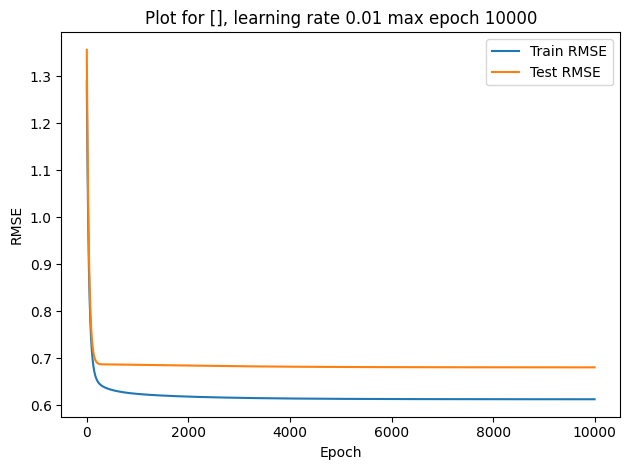

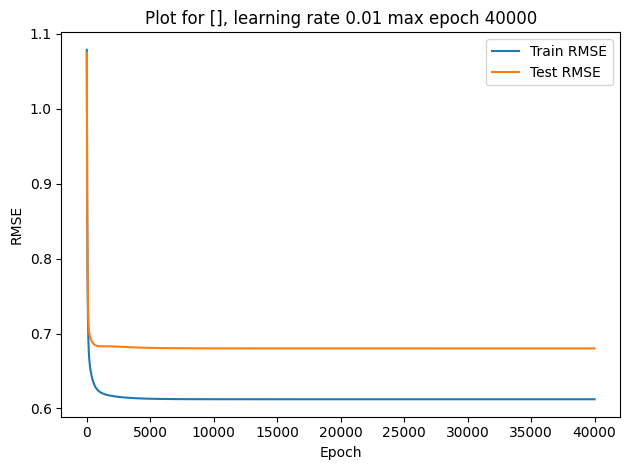

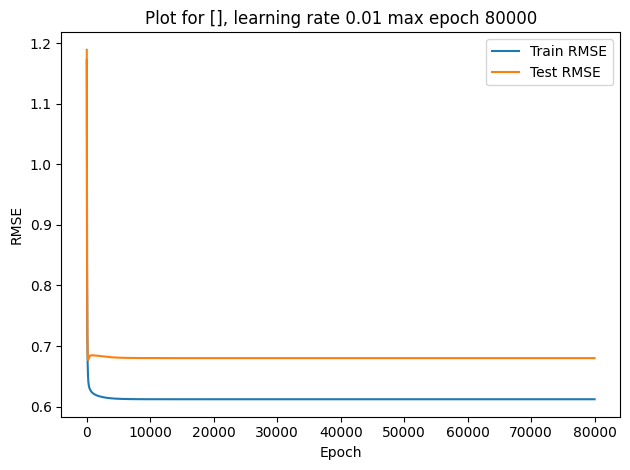

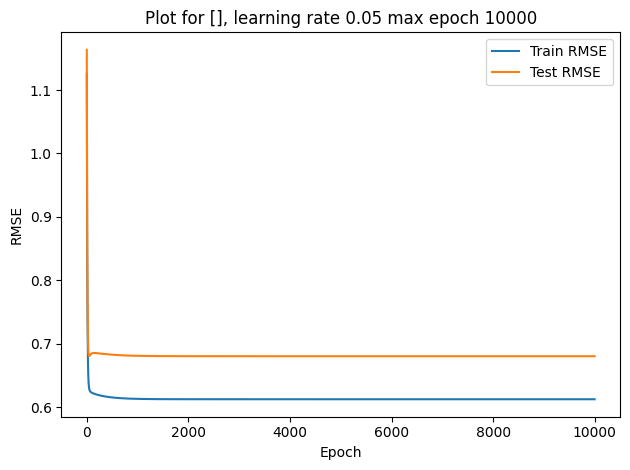

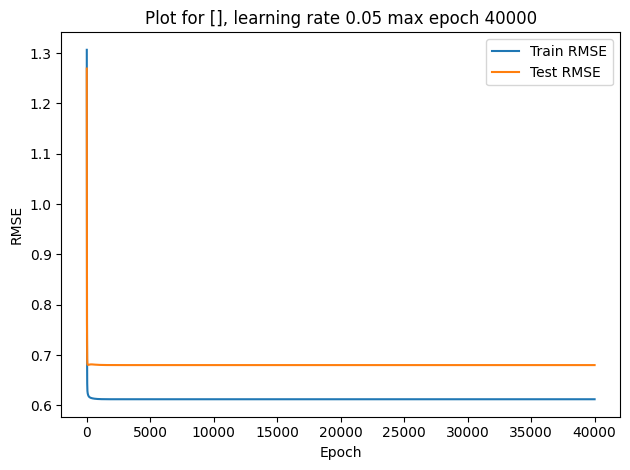

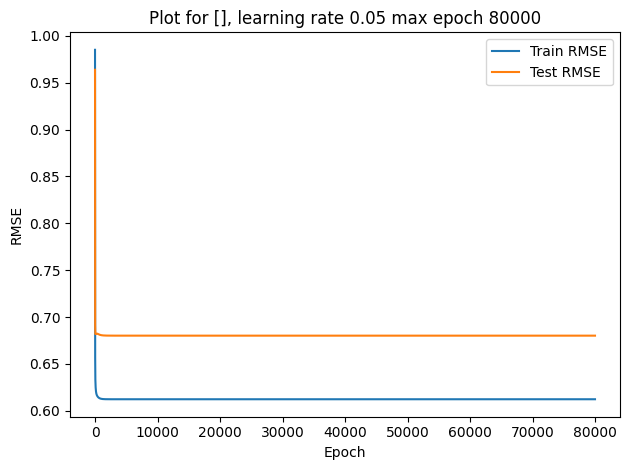

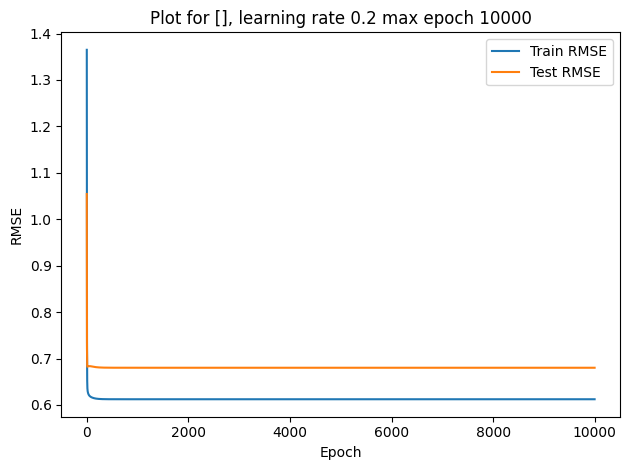

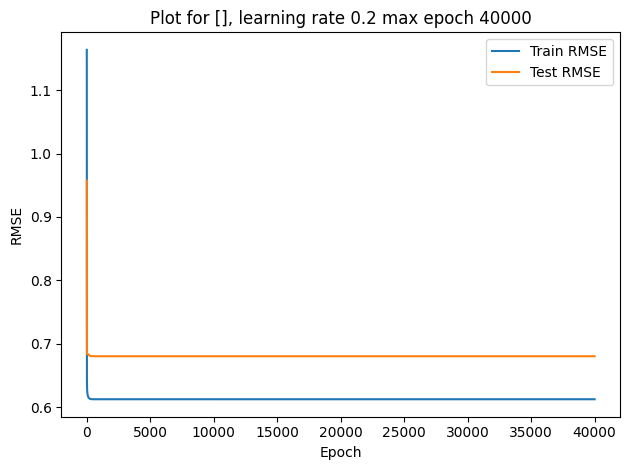

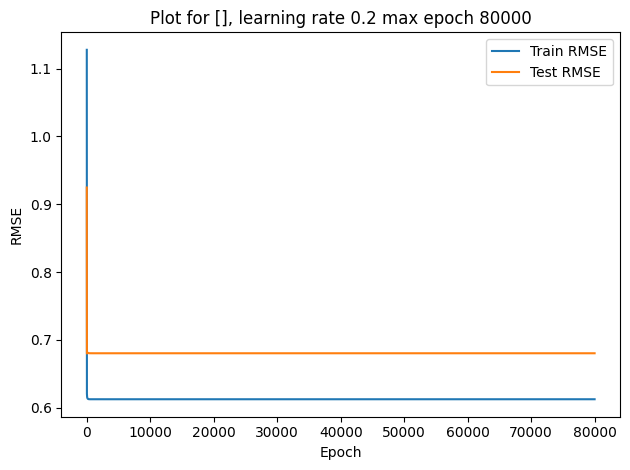

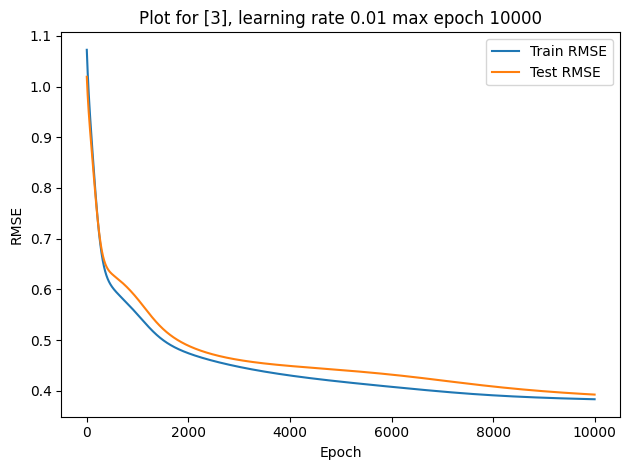

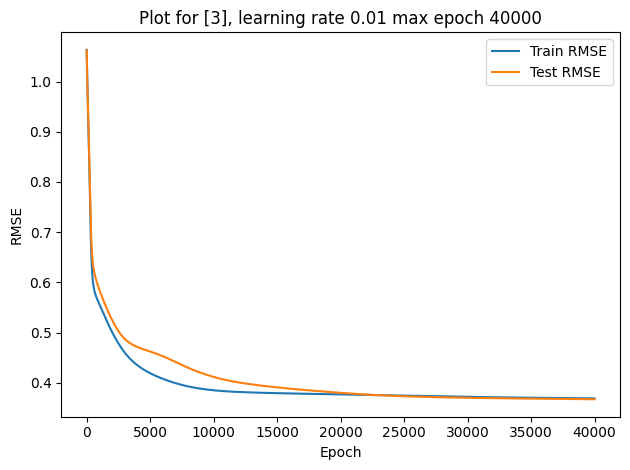

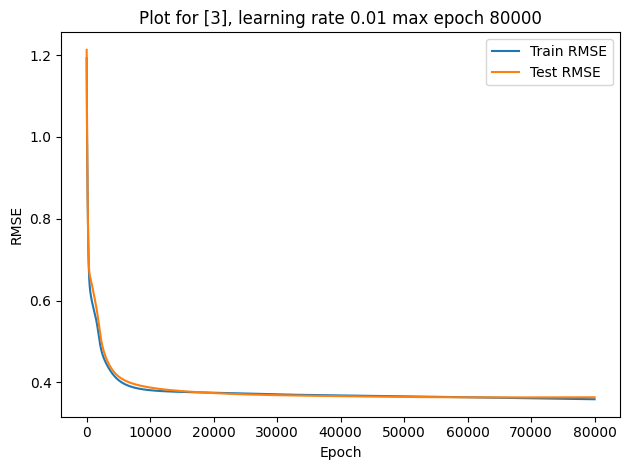

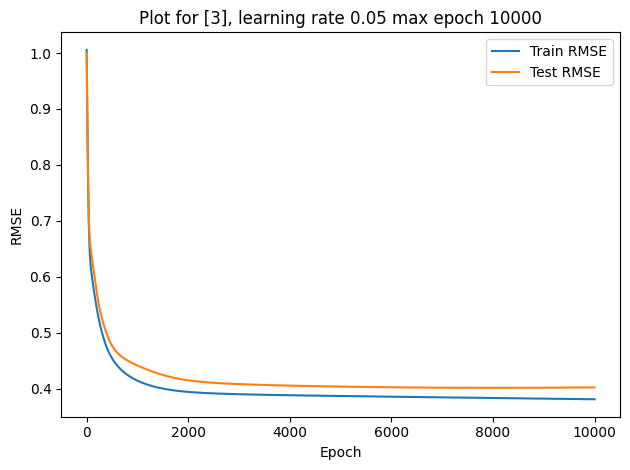

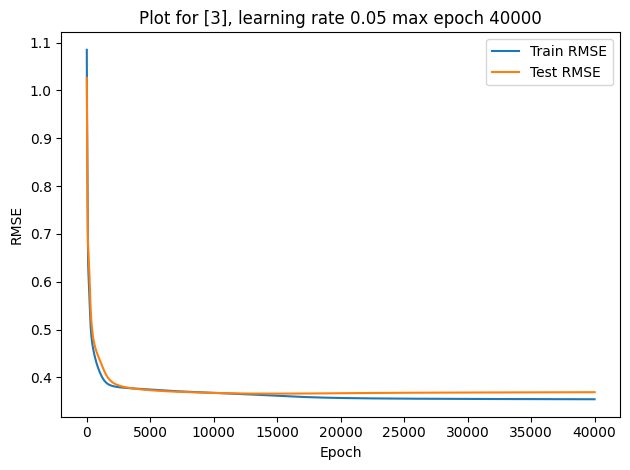

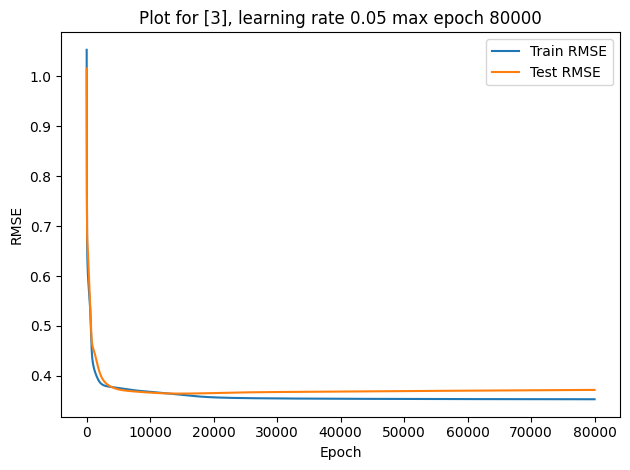

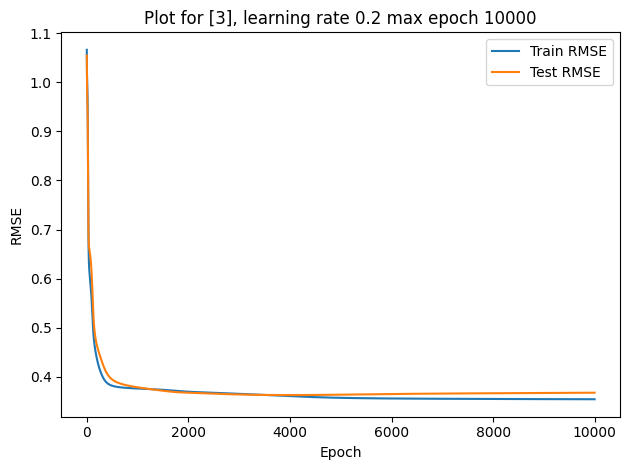

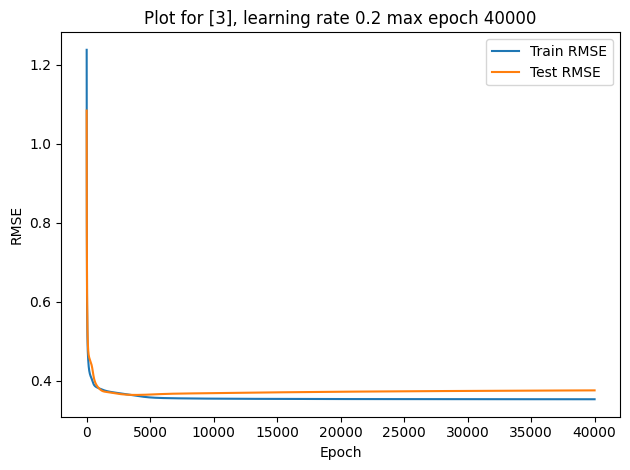

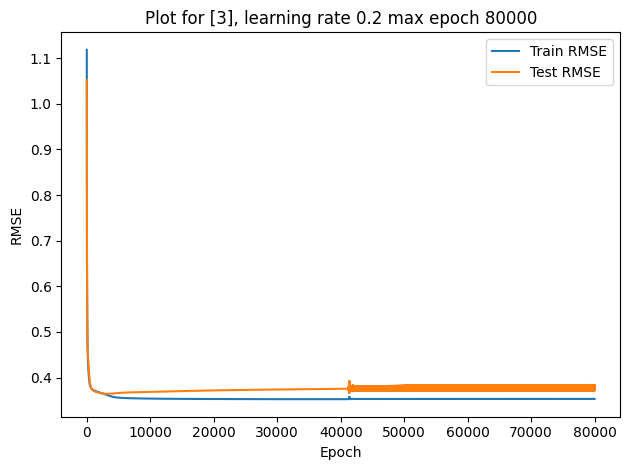

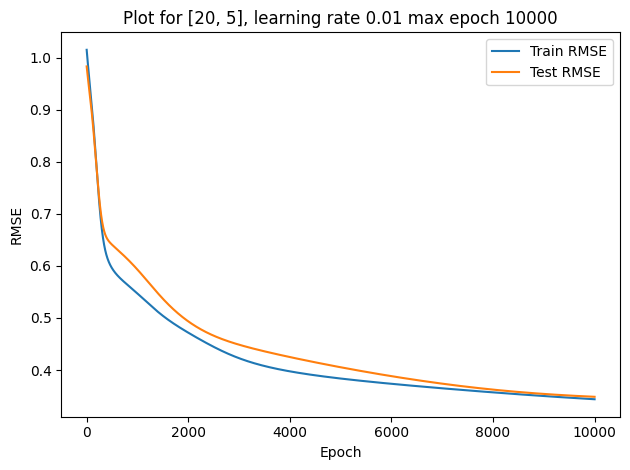

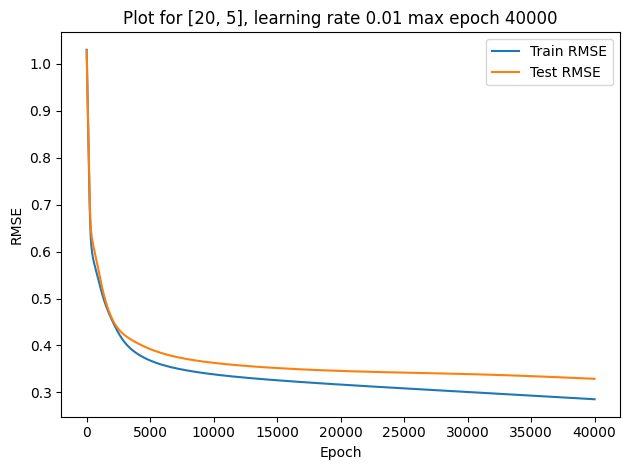

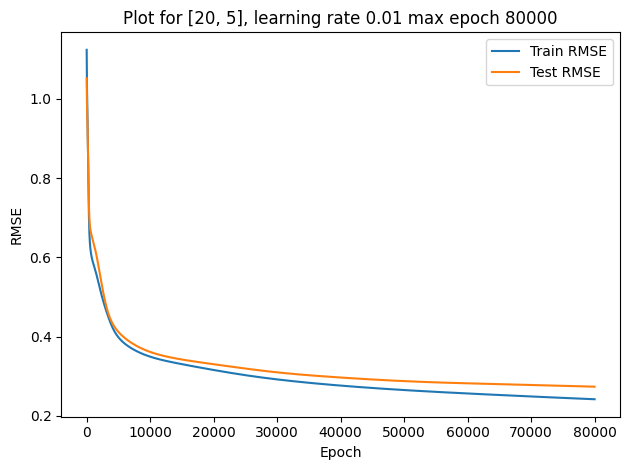

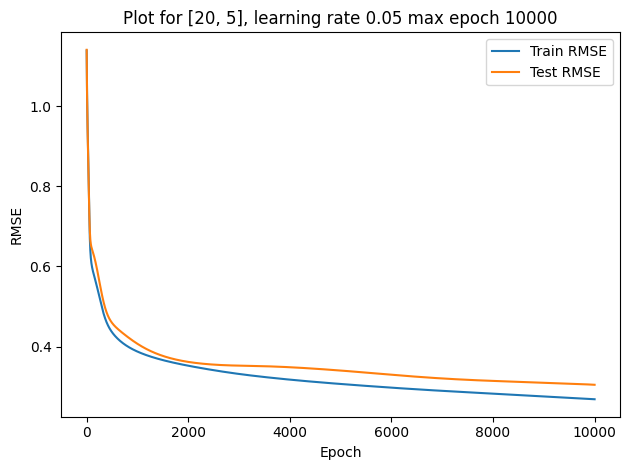

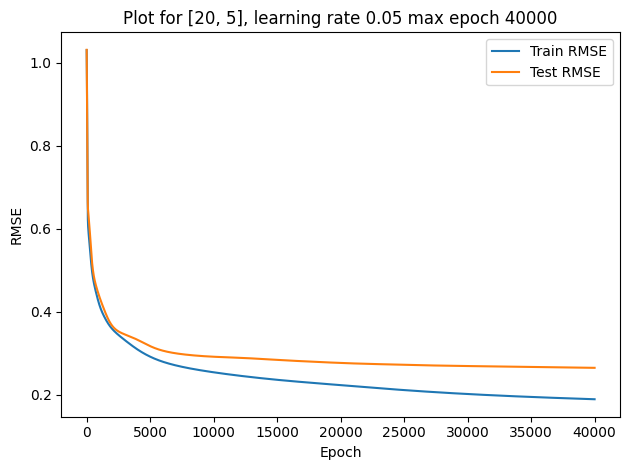

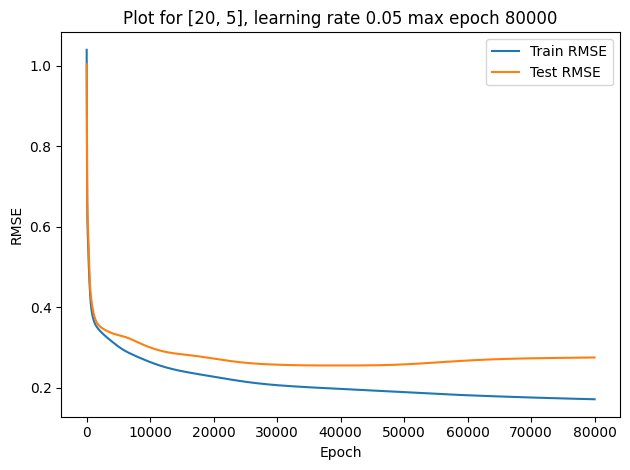

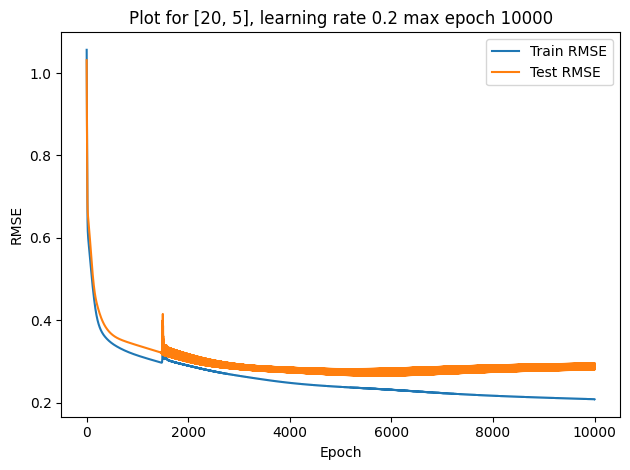

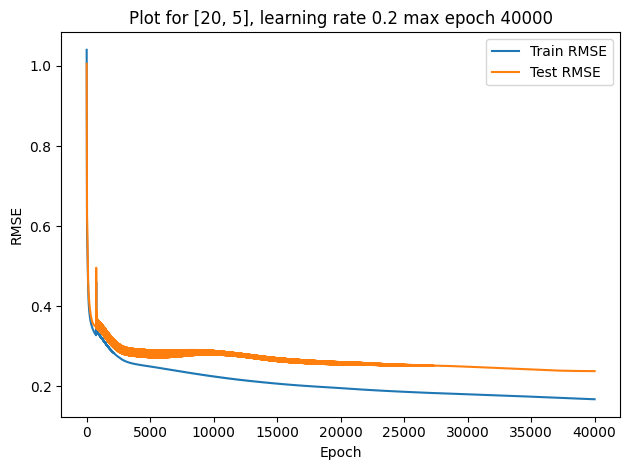

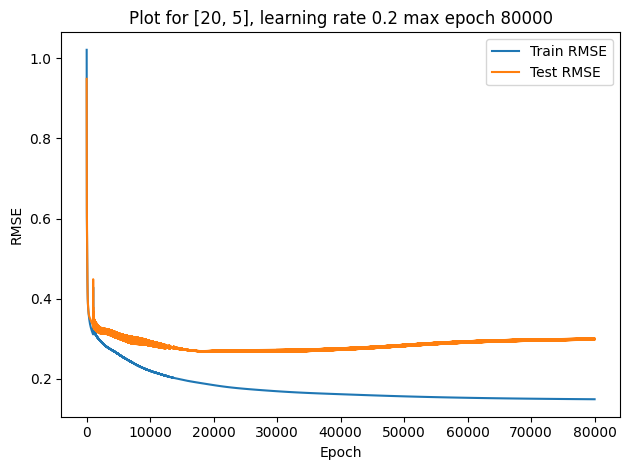

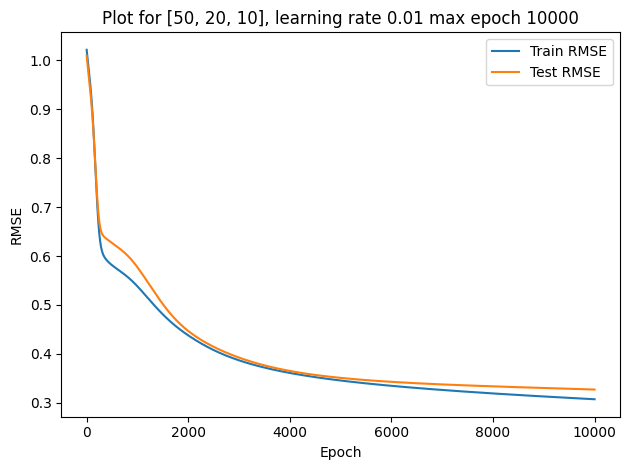

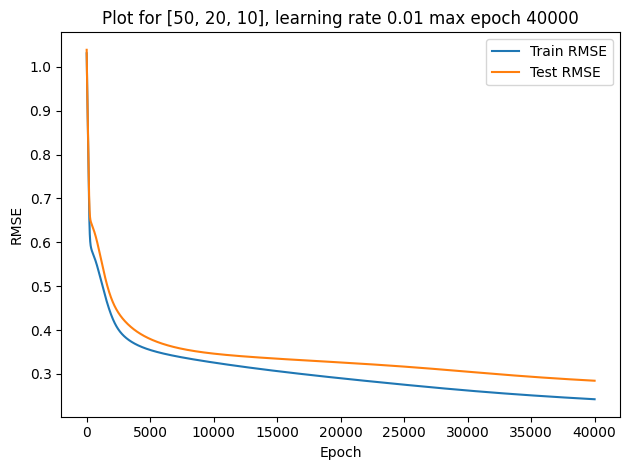

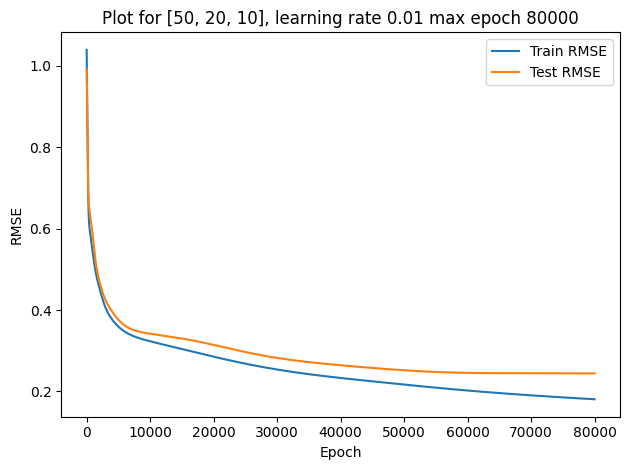

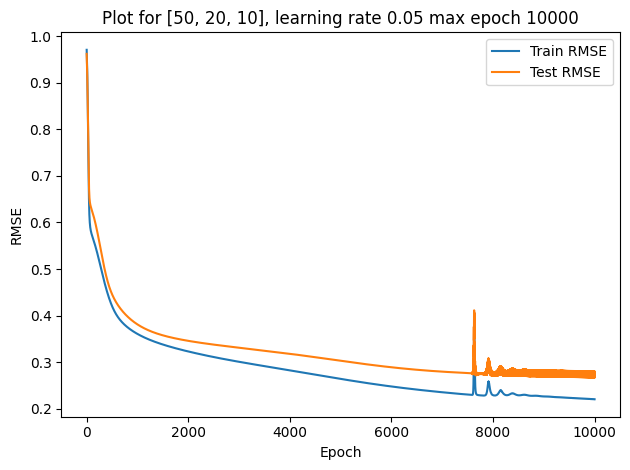

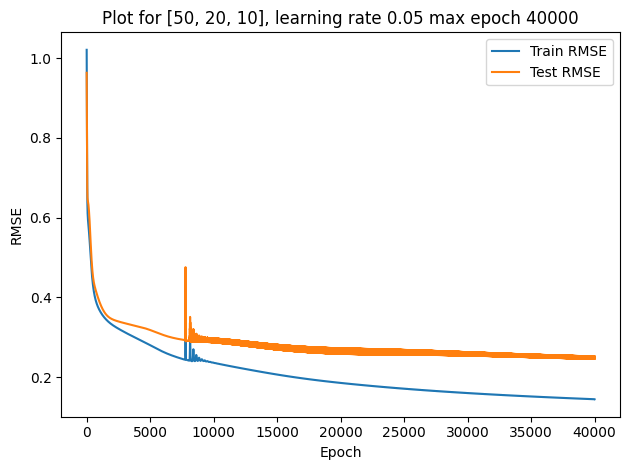

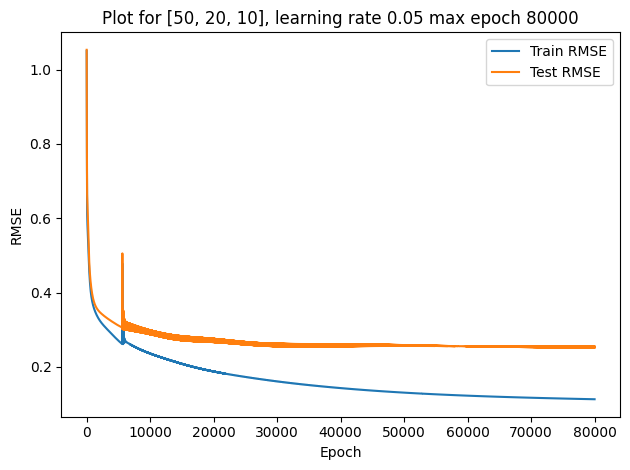

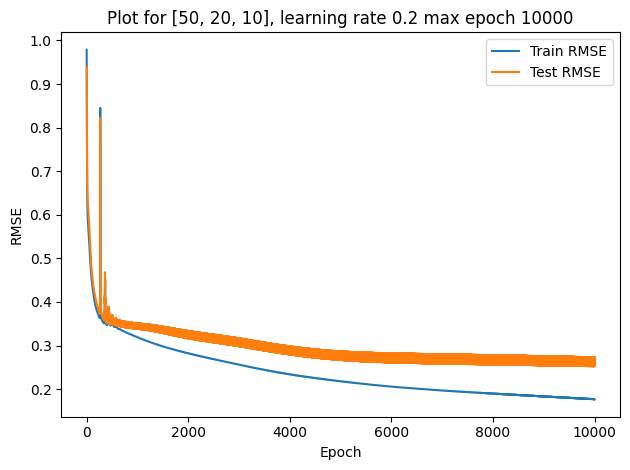

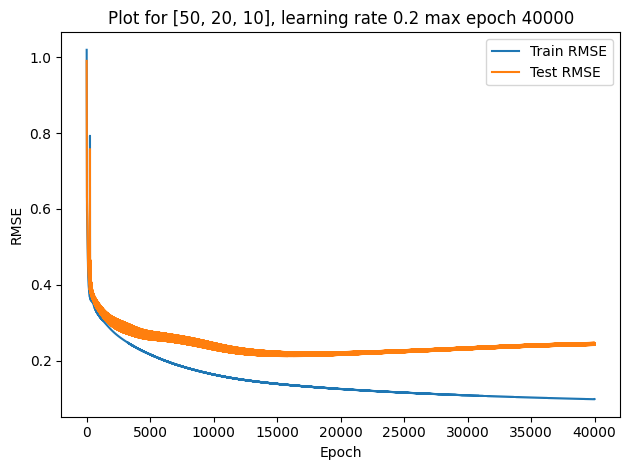

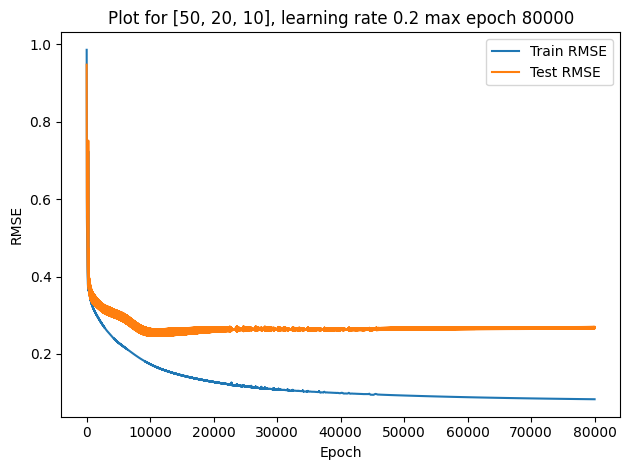

In [31]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]

epochs = [10000, 40000, 80000]
learning_rates = [0.01,0.05,0.2]

structures = [[],[3],[20,5],[50,20,10]]

result = []

for structure in structures:
  for learning_rate in learning_rates:
    for n_epochs in epochs:
      nnet = NeuralNetwork(n_inputs, structure, n_outputs)
      nnet.train(Xtrain, Ttrain, Xtest, Ttest, n_epochs, learning_rate)
      result.append([structure,learning_rate,n_epochs, nnet.rmse_trace[-1][0], nnet.rmse_trace[-1][1]])
      fig = plt.figure()
      plt.clf()
      plt.plot(nnet.rmse_trace)
      plt.xlabel('Epoch')
      plt.ylabel('RMSE')
      plt.legend(('Train RMSE', 'Test RMSE'))
      plt.title(f'Plot for {structure}, learning rate {learning_rate} max epoch {n_epochs}')
      fig.tight_layout()


In [34]:
df = pandas.DataFrame(result)

# Optionally, you can set column names if needed
column_names = ['Structure','Learning Rate', 'Epochs', 'Train RMSE', 'Test RMSE']
df.columns = column_names
df

,Structure,Learning Rate,Epochs,Train RMSE,Test RMSE
0,[],0.01,10000,0.612320,0.680216
1,[],0.01,40000,0.612281,0.680134
2,[],0.01,80000,0.612281,0.680134
3,[],0.05,10000,0.612281,0.680134
4,[],0.05,40000,0.612281,0.680134
5,[],0.05,80000,0.612281,0.680134
6,[],0.20,10000,0.612281,0.680134
7,[],0.20,40000,0.612281,0.680134
8,[],0.20,80000,0.612281,0.680134
9,[3],0.01,10000,0.383126,0.392339


In [43]:
# dataframe sorted in ascending order of train rmse and test rmse
df.sort_values(by=['Test RMSE', 'Train RMSE'], ascending=[True, False])

,Structure,Learning Rate,Epochs,Train RMSE,Test RMSE
25,"[20, 5]",0.20,40000,0.167338,0.237565
34,"[50, 20, 10]",0.20,40000,0.098463,0.241451
29,"[50, 20, 10]",0.01,80000,0.180608,0.244151
31,"[50, 20, 10]",0.05,40000,0.144595,0.251958
32,"[50, 20, 10]",0.05,80000,0.112898,0.252118
22,"[20, 5]",0.05,40000,0.189373,0.265135
30,"[50, 20, 10]",0.05,10000,0.220477,0.267628
35,"[50, 20, 10]",0.20,80000,0.083033,0.269873
33,"[50, 20, 10]",0.20,10000,0.176768,0.273063
20,"[20, 5]",0.01,80000,0.241588,0.273270


Discussion:

From the above dataframe, it can be observed that we obtain the highest Test RMSE for a neural network with no hidden layers. This means that a linear model performed the least to approximate the given values. As we introduce some non-linearity by adding a hidden layer with 3 units, the RMSE decreases significantly. For this instance, it can also be seen that increasing the learning rate doesn't provide significant improvement relative to initial values. A high learning rate of `0.2` does make the model fit quickly within `10,000` epochs, but a learning rate of `0.01` seems suitable which fits within `40,000` epochs. This means even though higher learning rate provides faster results, it might not be the optimal solution for the trained neural network.

The peformance of model seems to improve with lower RMSE values as we increase the number of hidden layers and units in each layer. The results for model with 3 hidden layers shows that it fits relatively quick compared to one with 2 hidden layers. But the three layered model overfits with lowest `0.083033` training value whereas the test rmse is `0.269873`. This is the highest difference between the training rmse and test rmse. The model performs too well on training data but doesn't perform relatively well in testing data. This means higher complexity of neural network with more hidden layers doesn't necessarily provide a better solution.

Considering the range of the target values being `80.27`, and the test rmse being `~0.25`, I think a model with two hidden layers would have a decent performance for this dataset. It can predict values of concrete strength with considerable accuracy and would perform well when deployed. However, a much thorough experimentation would be needed before being used in the real world.

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.zip) and unzip `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 20 points will be based on your discussion of this assignment.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as `A2solution.ipynb`, and then save this notebook.  Check in your `A2solution.ipynb` notebook when you are ready.

In [1]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named A2solution.ipynb and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.


C:\Users\diloc\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED



Testing

    n_inputs = 3
    n_hiddens = [2, 1]
    n_outputs = 2
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.hstack((X, X*2))

    nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.set_weights_for_testing()

    # Set standardization variables so use() will run
    nnet.X_means = 0
    nnet.X_stds = 1
    nnet.T_means = 0
    nnet.T_stds = 1
    
    Y = nnet.use(X)

Weights set for testing by calling set_weights_for_testing()

--- 20/20 points. Returned correct value.

Testing

    n_inputs = 3
    n_hiddens = []   # NO HIDDEN LAYERS.  SO THE NEURAL NET IS JUST A LINEAR MODEL.
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.hstack((X, X*2))
    n_outputs = T.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.set_weights_for_testing()

    nnet.train(X, T, X, T, 1000, 0.01)
    Y = nnet.use(X)

Weights set for testing by calling s

# Extra Credit

Apply your multilayer neural network code to a regression problem using data that you choose
from the [UCI Machine Learning Repository](https://archive.ics.uci.edu) or the [Kaggle Datasets](https://www.kaggle.com/datasets). Pick a dataset that
is listed as being appropriate for regression.

In [53]:
# The Boston house-price data of Harrison, D. and Rubinfeld, D.L.
# 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.
data = pandas.read_csv('boston.csv')

# Attribute Information
# Input features in order:
# 1) CRIM: per capita crime rate by town
# 2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
# 3) INDUS: proportion of non-retail business acres per town
# 4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
# 5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
# 6) RM: average number of rooms per dwelling
# 7) AGE: proportion of owner-occupied units built prior to 1940
# 8) DIS: weighted distances to five Boston employment centres
# 9) RAD: index of accessibility to radial highways
# 10) TAX: full-value property-tax rate per $10,000 [$/10k]
# 11) PTRATIO: pupil-teacher ratio by town
# 12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
# 13) LSTAT: % lower status of the population

# Output variable:
# 1) MEDV: Median value of owner-occupied homes in $1000's [k$]

# Source
# StatLib - Carnegie Mellon University

data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [54]:
X = data.drop('MEDV', axis=1).values
T = data['MEDV'].values
X.shape, T.shape

((506, 13), (506,))

In [59]:
Xd = data.iloc[:, range(13)]
X_names = Xd.columns
X = Xd.values

Td = data.iloc[:, 13:14]
T_names = Td.columns
T = Td.values

X.shape, X_names, T.shape, T_names

((506, 13),
 Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
        'PTRATIO', 'B', 'LSTAT'],
       dtype='object'),
 (506, 1),
 Index(['MEDV'], dtype='object'))

In [61]:
rows = np.arange(X.shape[0])
np.random.shuffle(rows)
ntrain = int(0.9 * len(rows))

Xtrain = X[rows[:ntrain], :]
Ttrain = T[rows[:ntrain], :]
Xtest = X[rows[ntrain:], :]
Ttest = T[rows[ntrain:], :]

print(f'Boston Housing: {Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}')

Boston Housing: Xtrain.shape=(455, 13), Ttrain.shape=(455, 1), Xtest.shape=(51, 13), Ttest.shape=(51, 1)


Final Train RMSE0.5123460661821223 and Test RMSE 0.441721354027346


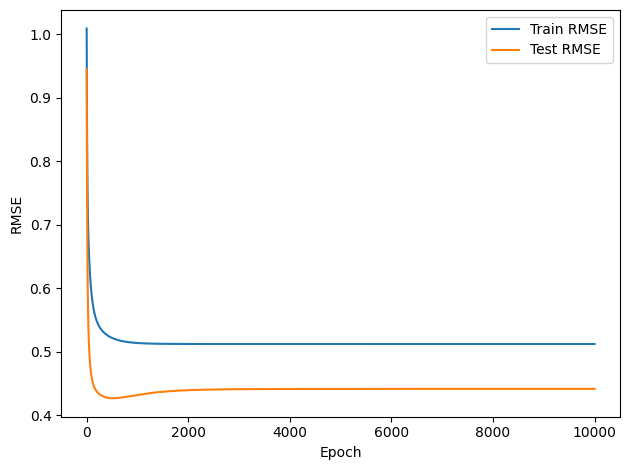

In [62]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [], n_outputs)
nnet.train(Xtrain, Ttrain, Xtest, Ttest, n_epochs=10000, learning_rate=0.01)
fig = plt.figure()
plt.clf()
plt.plot(nnet.rmse_trace)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(('Train RMSE', 'Test RMSE'))
fig.tight_layout()

print(f"Final Train RMSE{nnet.rmse_trace[-1][0]} and Test RMSE {nnet.rmse_trace[-1][1]}")


Final Train RMSE0.307017952827358 and Test RMSE 0.3143111156855999


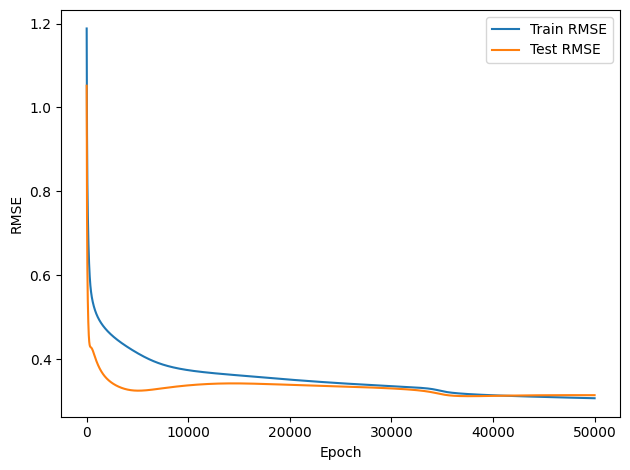

In [63]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [3], n_outputs)
nnet.train(Xtrain, Ttrain, Xtest, Ttest, n_epochs=50000, learning_rate=0.01)
fig = plt.figure()
plt.clf()
plt.plot(nnet.rmse_trace)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(('Train RMSE', 'Test RMSE'))
fig.tight_layout()

print(f"Final Train RMSE{nnet.rmse_trace[-1][0]} and Test RMSE {nnet.rmse_trace[-1][1]}")


Final Train RMSE0.2359266689659403 and Test RMSE 0.28873327248762753


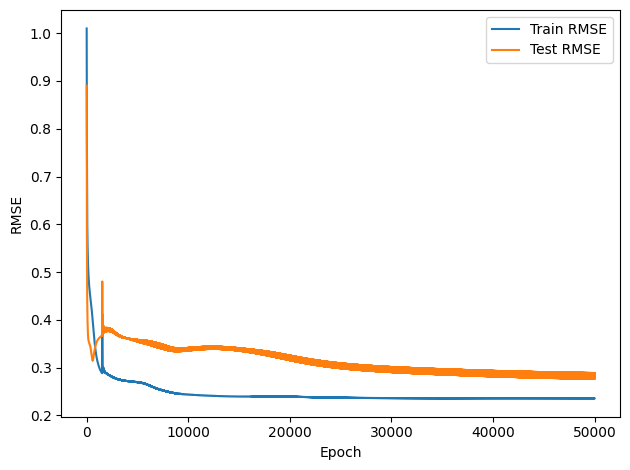

In [64]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [5,1], n_outputs)
nnet.train(Xtrain, Ttrain, Xtest, Ttest, n_epochs=50000, learning_rate=0.1)
fig = plt.figure()
plt.clf()
plt.plot(nnet.rmse_trace)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(('Train RMSE', 'Test RMSE'))
fig.tight_layout()

print(f"Final Train RMSE{nnet.rmse_trace[-1][0]} and Test RMSE {nnet.rmse_trace[-1][1]}")
